In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from evaluate_paddlepaddle import evaluate
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from data_loader import make_train_data, make_val_data, make_test_data, generate_dataset
from preprocessing import preprocess, marking_data   
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU,Conv1D ,Dropout,Conv1DTranspose, Bidirectional, TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from os import path, environ
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

environ["CUDA_VISIBLE_DEVICES"] = "2"
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


2022-07-15 23:15:17.352951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 23:15:17.366593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 23:15:17.367854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
SEQ_LEN = 2
BATCH_SIZE = 256 
EPOCHS = 1000

In [4]:
# Load dataset
full_data = pd.read_csv("data/wtbdata_245days.csv")
train_data = pd.read_csv("data/train_data.csv")
submission = pd.read_csv("data/sample_submission.csv")
test_data = pd.read_csv("info/target.csv")
full_data = full_data.fillna(method = 'bfill')
train_data = train_data.fillna(method = 'bfill')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [5]:
# Preprocessing
full_data = preprocess(full_data)

In [6]:
full_data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3',
       'Prtv', 'Patv', 'locX', 'locY', 'TimeX', 'TimeY', 'DayX', 'DayY', 'Etmp_abs', 'Wdir_adj',
       'WdirX', 'WdirY', 'NdirX', 'NdirY', 'WspdX', 'WspdY', 'WspdX_abs', 'WspdY_abs', 'TSR1',
       'TSR2', 'TSR3', 'Bspd1', 'Bspd2', 'Bspd3', 'Pab', 'RPM', 'TSR', 'Wspd_cube', 'P_max',
       'Papt', 'Patan'],
      dtype='object')

In [7]:
data = full_data.copy()

In [8]:
train_data = data[data['Day']<201]

### best feature score 16

In [9]:
features = ['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'WspdX', 'Wspd', 'Wspd_cube', 'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
train_data = train_data[features]
data = data[features]

## new feature

In [ ]:
features = ['TurbID','Day', 'Patan', 'TSR',  'Pab','P_max', 'Wspd_cube', 'Wspd', 'WspdX', 'RPM',
       'Papt', 'Patv']
train_data = train_data[features]
data = data[features]

In [ ]:
features = ['TurbID','Day', 'Bspd1', 'Bspd3', 'Bspd2', 'WspdX', 'Wspd', 'Wspd_cube', 'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
train_data = train_data[features]
data = data[features]

In [10]:
train_data

,TurbID,Day,RPM,Bspd1,Bspd3,Bspd2,WspdX,Wspd,Wspd_cube,P_max,Pab1,Pab2,Pab3,TSR1,TSR2,TSR3,Prtv,Patv
0,1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
1,1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
2,1,1,16.322087,16.322087,16.322087,16.322087,6.265462,6.27,245.957079,0.900427,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.24,509.76
3,1,1,16.723314,16.723314,16.723314,16.723314,6.419479,6.42,264.544863,0.966892,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.26,542.53
4,1,1,16.279842,16.279842,16.279842,16.279842,6.249246,6.25,244.052275,0.892196,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721035,134,200,13.300998,13.300998,13.300998,13.300998,4.843796,4.86,113.646913,0.455178,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.13,308.65
4721036,134,200,12.217265,12.217265,12.217265,12.217265,4.449136,4.46,88.069787,0.352134,0.01,0.01,0.01,2.745986,2.745986,2.745986,-93.64,221.60
4721037,134,200,11.615510,11.615510,11.615510,11.615510,4.229996,4.23,75.686746,0.300476,0.01,0.01,0.01,2.745986,2.745986,2.745986,-111.20,220.60
4721038,134,200,11.904266,11.904266,11.904266,11.904266,4.335151,4.36,81.472834,0.329171,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.04,222.15


In [29]:
def make_test_data(data, seq_len):
    test_x, test_y = [], []
    for j in range(201, 202):
        test_days = np.arange(j, j+seq_len)
        label_days = np.arange(j+seq_len, j+seq_len+2)
        test_tmp = data[data.Day.isin(test_days)].drop(columns=['TurbID','Day'])
        label_tmp = data[data.Day.isin(label_days)].drop(columns=['TurbID','Day'])
        test_x.append(test_tmp)  # (720, 11) = (Tmstamp * days, n_features)
        test_y.append(label_tmp)  # (288)     = (Tmstamp * days)
    test_x, test_y = np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)
    return np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)

In [30]:
# Split data

train_x, train_y = make_train_data(train_data, SEQ_LEN)
# val_x,   val_y   = make_val_data(data, SEQ_LEN)
test_x, test_y   = make_test_data(data, SEQ_LEN)
# val_x,   val_y   = val_x.reshape(-1, *train_x.shape[1:]), val_y.reshape(-1, train_y.shape[1])
test_x, test_y   = test_x.reshape(-1, *train_x.shape[1:]),test_y.reshape(-1, *train_y.shape[1:])
print("Train data(X, y):", train_x.shape, train_y.shape)
# print("Val data(X, y):", val_x.shape, val_y.shape)
print("Test data(X, y):", test_x.shape, test_y.shape)

100%|██████████| 134/134 [01:13<00:00,  1.81it/s]


Train data(X, y): (26264, 288, 16) (26264, 288, 16)
Test data(X, y): (134, 288, 16) (134, 288, 16)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_data.iloc[:,2:])
train_x_scaled = scaler.transform(train_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
train_y_scaled = scaler.transform(train_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_x_scaled = scaler.transform(test_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_y_scaled = scaler.transform(test_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
print("Train data(X, y):", train_x_scaled.shape, train_y_scaled.shape)
print("Test data(X, y):", test_x_scaled.shape, test_y_scaled.shape)

In [32]:
# Generate dataset
train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE)

In [33]:
test_ds = generate_dataset(test_x, test_y, batch_size=BATCH_SIZE)

In [34]:
model = Sequential(
    [
        Input(shape=(train_x.shape[1], train_x.shape[2])),
        Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(filters=16, kernel_size=7, padding="same"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           3616      
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                            

In [35]:
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(train_x.shape[1],train_x.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(train_y.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
# model.add(RepeatVector(train_y.shape[1], name='Repeat-Vector-Layer2')) # Repeat Vector
model.add(TimeDistributed(Dense(units=train_y.shape[2], activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

In [36]:
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              420864    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 16)          8208      
 ed)                                                             
                                                                 
Total params: 1,611,792
Trainable params: 1,611,792
Non-t

In [37]:
##### Step 4 - Compile the model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

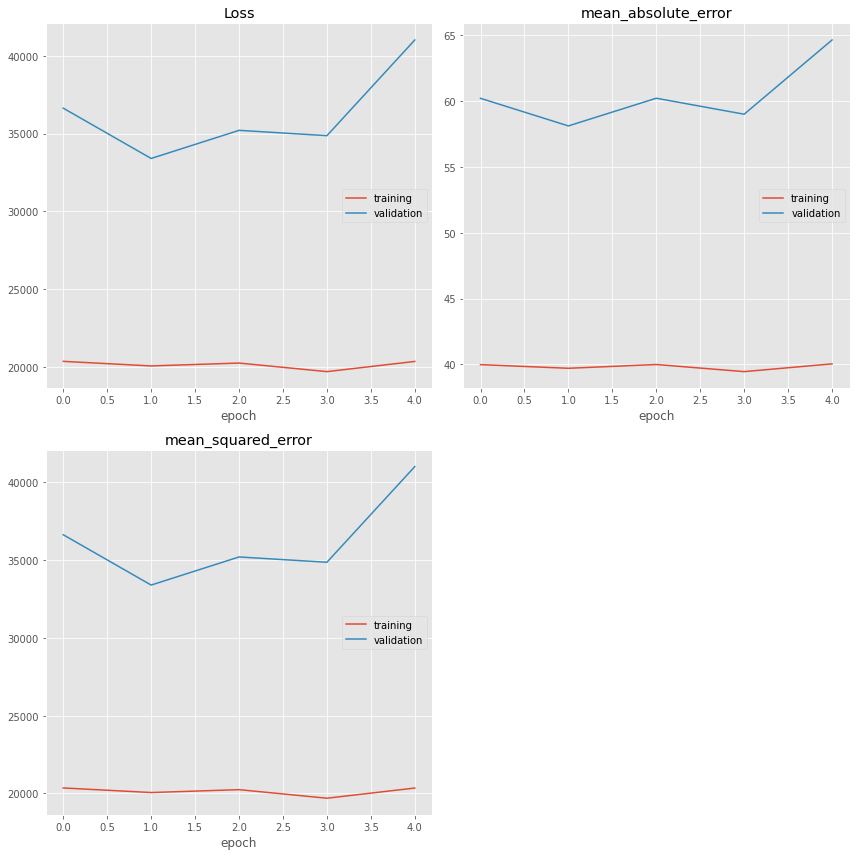

Loss
	training         	 (min: 19694.893, max: 20354.574, cur: 20350.188)
	validation       	 (min: 33403.625, max: 41022.945, cur: 41022.945)
mean_absolute_error
	training         	 (min:   39.458, max:   40.046, cur:   40.046)
	validation       	 (min:   58.108, max:   64.630, cur:   64.630)
mean_squared_error
	training         	 (min: 19694.885, max: 20354.580, cur: 20350.188)
	validation       	 (min: 33403.625, max: 41022.945, cur: 41022.945)
103/103 [==============================] - 18s 174ms/step - loss: 20350.1875 - mean_squared_error: 20350.1875 - mean_absolute_error: 40.0455 - val_loss: 41022.9453 - val_mean_squared_error: 41022.9453 - val_mean_absolute_error: 64.6304
Epoch 6/1000
 18/103 [====>.........................] - ETA: 14s - loss: 19054.7676 - mean_squared_error: 19054.7676 - mean_absolute_error: 39.2661

In [ ]:
##### Step 5 - Fit the model on the dataset
history = model.fit(train_ds, # input data, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=1000, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=[ PlotLossesKeras(),EarlyStopping(patience=10, restore_best_weights=True)], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    #validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    validation_data=test_ds, # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=False, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )
now = datetime.now()
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
model.save(f'saved_models/model_ep{EPOCHS}_b{BATCH_SIZE}_seq{SEQ_LEN}_{current_time}')

In [43]:
##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(test_x, test_y)
print("")
print('-------------------- Accuracy and Score --------------------')
test_data = data[(data['Day']>=199)&(data['Day']<=200)]
test_data.drop(['TurbID','Day'], axis = 1, inplace = True)
test_data = test_data.to_numpy().reshape(-1, *train_x.shape[1:])

submission['Patv'] =model.predict(test_data).reshape(-1,train_x.shape[2])[:,-1]
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))



-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              420864    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 16)          8208      
 ed)                                                             
                                                                 


1) Training set

In [ ]:
y_true = train_y[:, :, -1]
y_pred = model.predict(train_x)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

2) Validation set

In [ ]:
y_true = test_y[:, :, -1]
y_pred = model.predict(test_x)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

# Result

Accuracy:  74.2568%

 	 RMSE: 270.7720392028413, MAE: 201.78096543039558

 --- Overall Score --- 
	236.27650231661846
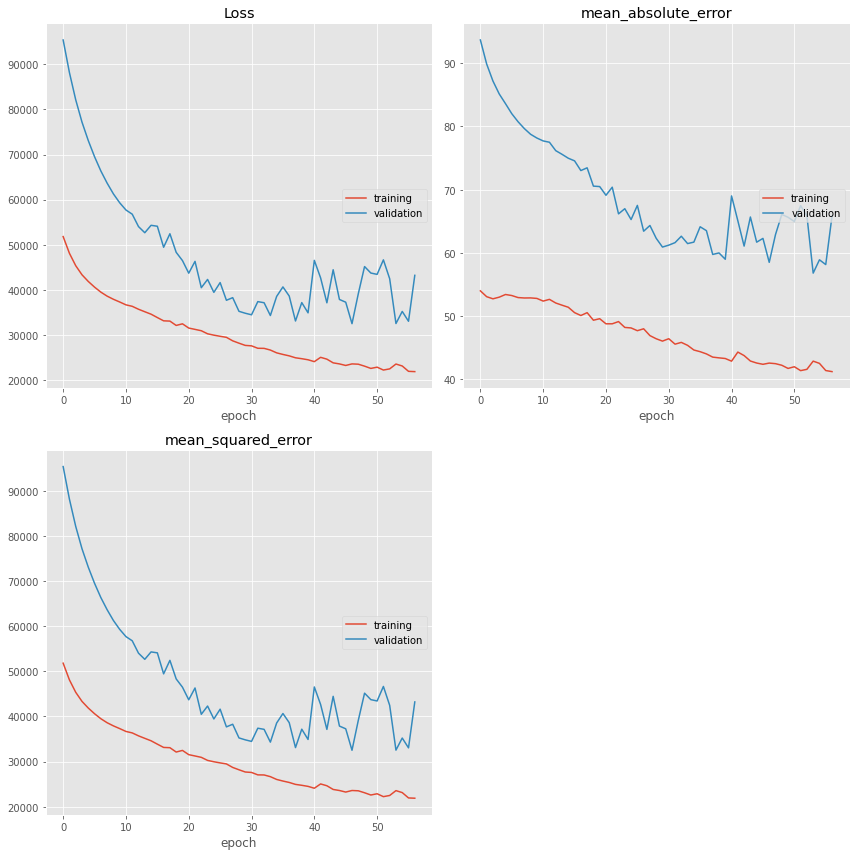

Accuracy:  74.1243%

 	 RMSE: 263.55983622247567, MAE: 198.45302289611524

 --- Overall Score --- 
	231.00642955929544
    
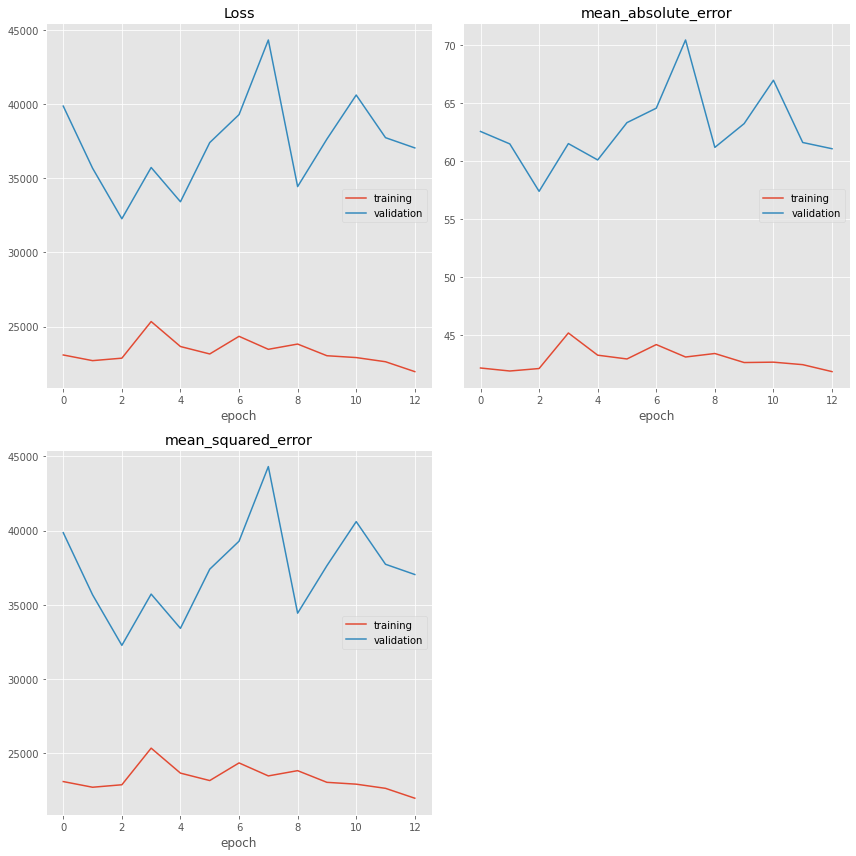

Accuracy:  72.7549%

 	 RMSE: 271.1959724812274, MAE: 195.34172940959004

 --- Overall Score --- 
	233.2688509454087

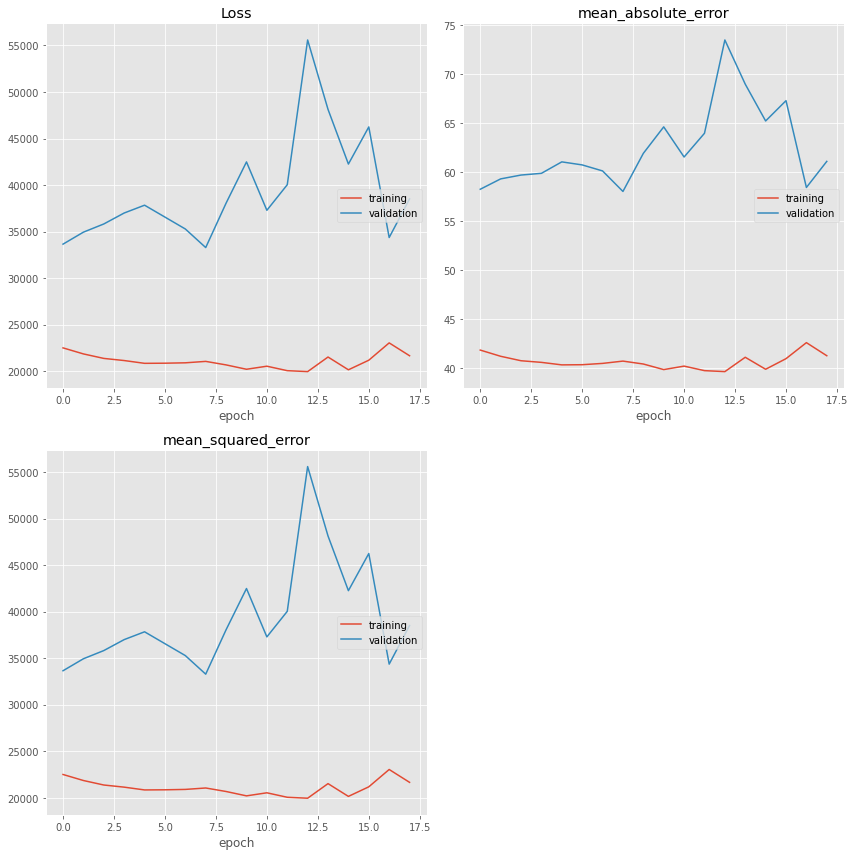

Loss
	training         	 (min: 19945.293, max: 23032.846, cur: 21651.830)
	validation       	 (min: 33278.938, max: 55590.004, cur: 38505.527)
mean_absolute_error
	training         	 (min:   39.662, max:   42.620, cur:   41.285)
	validation       	 (min:   58.056, max:   73.521, cur:   61.127)
mean_squared_error
	training         	 (min: 19945.287, max: 23032.848, cur: 21651.824)
	validation       	 (min: 33278.938, max: 55590.004, cur: 38505.527)
103/103 [==============================] - 18s 173ms/step - loss: 21651.8301 - mean_squared_error: 21651.8242 - mean_absolute_error: 41.2846 - val_loss: 38505.5273 - val_mean_squared_error: 38505.5273 - val_mean_absolute_error: 61.1267
WARNING:absl:Function `_wrapped_model` contains input name(s) Input-Layer with unsupported characters which will be renamed to input_layer in the SavedModel.
WARNING:absl:Found untraced functions such as gru_cell_13_layer_call_fn, gru_cell_13_layer_call_and_return_conditional_losses, gru_cell_14_layer_call_fn, gru_cell_14_layer_call_and_return_conditional_losses, gru_cell_16_layer_call_fn while saving (showing 5 of 8). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: saved_models/model_ep1000_b256_seq2_2022-07-16 02:21:35/assets